**NAIVE BAYES-XGBOOST-BERT**

**Importing Libraries**

In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

**Loading Data**

In [26]:
data = files.upload()

Saving Skin_text_classifier.csv to Skin_text_classifier (1).csv


In [27]:
df = pd.read_csv('Skin_text_classifier.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Disease name  143 non-null    object
 1   Text          143 non-null    object
dtypes: object(2)
memory usage: 2.4+ KB


,Disease name,Text
0,Vitiligo,"""I've had these light patches on my neck and f..."
1,Scabies,"""Doctor, I've noticed these small, red bumps o..."
2,Vitiligo,"""Doctor, I noticed a pale patch around my knee..."
3,Hives (Urticaria),"Hives, also known as urticaria, typically pres..."
4,Folliculitis,"""I have these small, hard bumps on my buttocks..."


**Text preprocessing**

In [28]:
#stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
#preprocessing function for text data (convert to lowercase, remove special characters, and stopwords)
def preprocess_text(text):
    #converting text to lowercase
    text = text.lower()

    #removing special characters & punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    #removing stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

#preprocessing function to Text column
df['Processed_Text'] = df['Text'].apply(preprocess_text)

#display of original text and the processed text for comparison
df[['Text', 'Processed_Text']].head()

,Text,Processed_Text
0,"""I've had these light patches on my neck and f...",ive light patches neck face years seem spreadi...
1,"""Doctor, I've noticed these small, red bumps o...",doctor ive noticed small red bumps wrists elbo...
2,"""Doctor, I noticed a pale patch around my knee...",doctor noticed pale patch around knee recently...
3,"Hives, also known as urticaria, typically pres...",hives also known urticaria typically present r...
4,"""I have these small, hard bumps on my buttocks...",small hard bumps buttocks hurt sit theyre red ...


Text vectorization

In [30]:
#initialize TF-IDF vectorizer for preprocessed text
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#fit & transform preprocessed text data
X_tfidf = tfidf_vectorizer.fit_transform(df['Processed_Text'])

#display shape of TF-IDF matrix (number of samples & features)
X_tfidf.shape

(143, 402)

TF-IDF vectorization results in a matrix with 143 samples & 402 unique features (words).

**MODELS**

**Naive Bayes**

In [31]:
#encoding the labels (Disease name)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Disease name'])

#split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

#Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

#prediction on the test set
y_pred = nb_classifier.predict(X_test)

#evaluate model using classification report
classification_report_result = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

classification_report_result

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

"                              precision    recall  f1-score   support\n\n                        Acne       0.50      0.50      0.50         2\nAthlete's Foot (Tinea Pedis)       1.00      0.50      0.67         4\n          Contact Dermatitis       1.00      0.50      0.67         4\n                      Eczema       0.00      0.00      0.00         1\n                Folliculitis       0.40      1.00      0.57         2\n           Hives (Urticaria)       0.00      0.00      0.00         3\n                    Impetigo       1.00      0.67      0.80         3\n                   Psoriasis       1.00      0.67      0.80         3\n   Ringworm (Tinea Corporis)       0.00      0.00      0.00         0\n                     Rosacea       1.00      0.50      0.67         2\n                     Scabies       0.00      0.00      0.00         3\n    Shingles (Herpes Zoster)       1.00      1.00      1.00         2\n                    Vitiligo       0.00      0.00      0.00         0\n\n 

Resampling

In [32]:
#initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

#apply oversampling to balance dataset
X_resampled, y_resampled = ros.fit_resample(X_tfidf, y)

#check distribution of classes before & after resampling
before_resampling = np.bincount(y)
after_resampling = np.bincount(y_resampled)

before_resampling, after_resampling


(array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]),
 array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]))

Tuning the TF-IDF vectorizer & retraining model on tuned features

In [33]:
#Tune the TF-IDF vectorizer with bigrams and adjusted min_df and max_df
tfidf_vectorizer_tuned = TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=2, stop_words='english')

#Fit and transform the preprocessed text data with the tuned TF-IDF
X_tfidf_tuned = tfidf_vectorizer_tuned.fit_transform(df['Processed_Text'])

#Split the data into training and testing sets
X_train_tuned, X_test_tuned, y_train, y_test = train_test_split(X_tfidf_tuned, y, test_size=0.2, random_state=42)

#Train the Naive Bayes classifier on the tuned TF-IDF features
nb_classifier_tuned = MultinomialNB()
nb_classifier_tuned.fit(X_train_tuned, y_train)

#Predict on the test set with the tuned model
y_pred_tuned = nb_classifier_tuned.predict(X_test_tuned)

#Evaluate the model performance after tuning the TF-IDF
classification_report_tuned = classification_report(y_test, y_pred_tuned, target_names=label_encoder.classes_)

classification_report_tuned

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

"                              precision    recall  f1-score   support\n\n                        Acne       0.33      0.50      0.40         2\nAthlete's Foot (Tinea Pedis)       1.00      0.50      0.67         4\n          Contact Dermatitis       1.00      0.50      0.67         4\n                      Eczema       0.00      0.00      0.00         1\n                Folliculitis       0.50      1.00      0.67         2\n           Hives (Urticaria)       0.00      0.00      0.00         3\n                    Impetigo       1.00      0.67      0.80         3\n                   Psoriasis       1.00      0.33      0.50         3\n   Ringworm (Tinea Corporis)       0.00      0.00      0.00         0\n                     Rosacea       0.50      0.50      0.50         2\n                     Scabies       0.00      0.00      0.00         3\n    Shingles (Herpes Zoster)       1.00      1.00      1.00         2\n                    Vitiligo       0.00      0.00      0.00         0\n\n 

**XGBoost**

In [34]:
#Initializing XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

#Trainning  XGBoost classifier on tuned TF-IDF features
xgb_classifier.fit(X_train_tuned, y_train)

#Predict on test set with XGBoost model
y_pred_xgb = xgb_classifier.predict(X_test_tuned)

#Adjust classification report to handle missing classes
classification_report_xgb_adjusted = classification_report(
    y_test, y_pred_xgb, labels=np.arange(len(label_encoder.classes_)), target_names=label_encoder.classes_, zero_division=0
)

classification_report_xgb_adjusted

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:45:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


"                              precision    recall  f1-score   support\n\n                        Acne       0.50      0.50      0.50         2\nAthlete's Foot (Tinea Pedis)       0.67      0.50      0.57         4\n          Contact Dermatitis       0.50      0.50      0.50         4\n                      Eczema       0.00      0.00      0.00         1\n                Folliculitis       0.50      1.00      0.67         2\n           Hives (Urticaria)       0.50      0.33      0.40         3\n                    Impetigo       1.00      0.33      0.50         3\n                   Psoriasis       1.00      0.67      0.80         3\n   Ringworm (Tinea Corporis)       0.00      0.00      0.00         0\n                     Rosacea       0.50      0.50      0.50         2\n                     Scabies       1.00      0.33      0.50         3\n    Shingles (Herpes Zoster)       0.50      0.50      0.50         2\n                    Vitiligo       0.00      0.00      0.00         0\n\n 

Randomized Search

In [35]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_random = RandomizedSearchCV(estimator=XGBClassifier(eval_metric='mlogloss'),
                                param_distributions=param_grid,
                                n_iter=50, cv=3, verbose=1, n_jobs=-1)
xgb_random.fit(X_train_tuned, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'gamma': [0, 0.1, 0.5],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.8, 1.0]},
                   verbose=1)

In [36]:
best_params = xgb_random.best_params_
print("Best parameters:", best_params)

Best parameters: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.8}


In [37]:
best_xgb = XGBClassifier(**best_params, eval_metric='mlogloss')
best_xgb.fit(X_train_tuned, y_train)
y_pred_best = best_xgb.predict(X_test_tuned)

#Evaluate the performance
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.67      0.50      0.57         4
           2       0.60      0.75      0.67         4
           3       0.00      0.00      0.00         1
           4       0.67      1.00      0.80         2
           5       1.00      0.33      0.50         3
           6       1.00      1.00      1.00         3
           7       1.00      0.67      0.80         3
           9       1.00      0.50      0.67         2
          10       1.00      0.33      0.50         3
          11       0.50      0.50      0.50         2
          12       0.00      0.00      0.00         0

    accuracy                           0.59        29
   macro avg       0.66      0.51      0.54        29
weighted avg       0.77      0.59      0.63        29



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Applying SMOTE

In [38]:
!pip install imbalanced-learn

In [39]:
#Applying SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf_tuned, y)

#Split resampled data into train & test sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#Train XGBoost model on SMOTE resampled data
xgb_smote = XGBClassifier(eval_metric='mlogloss')
xgb_smote.fit(X_train_smote, y_train_smote)

#Predict on test set
y_pred_smote = xgb_smote.predict(X_test_smote)

#Evaluate model performance
print(classification_report(y_test_smote, y_pred_smote))


              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.67      0.50      0.57         4
           2       0.50      0.50      0.50         4
           3       0.00      0.00      0.00         1
           4       0.50      1.00      0.67         2
           5       0.50      0.33      0.40         3
           6       1.00      0.33      0.50         3
           7       1.00      0.67      0.80         3
           9       0.50      0.50      0.50         2
          10       1.00      0.33      0.50         3
          11       0.50      0.50      0.50         2
          12       0.00      0.00      0.00         0

    accuracy                           0.48        29
   macro avg       0.56      0.43      0.45        29
weighted avg       0.66      0.48      0.52        29



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro Average Comparison

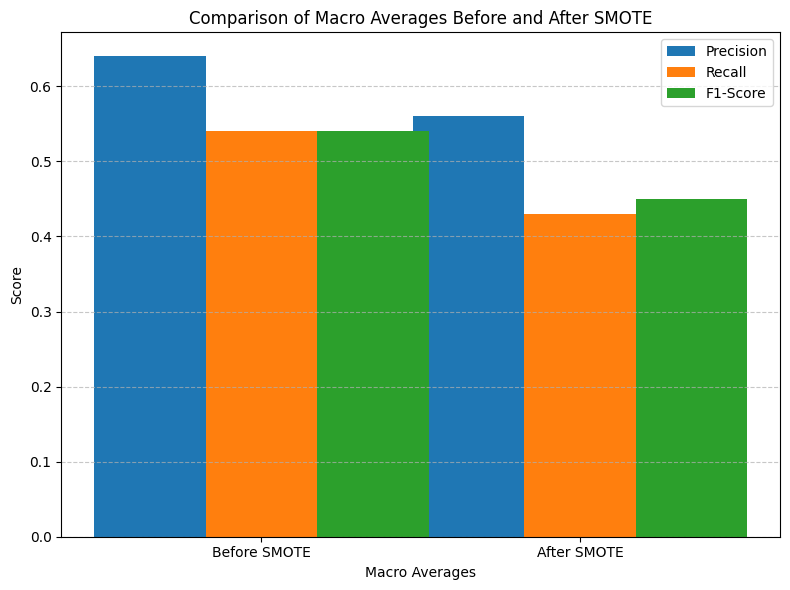

In [40]:
#data for macro averages before & after SMOTE
macro_averages = {
    'Before SMOTE': [0.64, 0.54, 0.54],
    'After SMOTE': [0.56, 0.43, 0.45]
}

#metric names and data for each scenario
metrics = list(macro_averages.keys())
precision, recall, f1_score = zip(*macro_averages.values())

#bar chart
plt.figure(figsize=(8, 6))
bar_width = 0.35
index = range(len(metrics))

plt.bar(index, precision, bar_width, label='Precision')
plt.bar([i + bar_width for i in index], recall, bar_width, label='Recall')
plt.bar([i + 2 * bar_width for i in index], f1_score, bar_width, label='F1-Score')

plt.xlabel('Macro Averages')
plt.ylabel('Score')
plt.title('Comparison of Macro Averages Before and After SMOTE')
plt.xticks([i + bar_width for i in index], metrics)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Training **XGBoost Model** with new features

In [41]:
#Adding a feature for the length of the text (number of words)
df['text_length'] = df['Processed_Text'].apply(lambda x: len(x.split()))

In [42]:
#Define important words related to symptoms
important_words = ['itchy', 'rash', 'red', 'bumps', 'spreading', 'blisters', 'dry']

#Create binary feature for the presence of each important word
for word in important_words:
    df[f'contains_{word}'] = df['Processed_Text'].apply(lambda x: 1 if word in x else 0)

In [43]:
#Update TF-IDF vectorizer to include bigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.95, min_df=2, stop_words='english')

#Transform processed text with TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(df['Processed_Text'])

In [44]:
#Create matrix combining TF-IDF features with the additional features
additional_features = df[['text_length'] + [f'contains_{word}' for word in important_words]]
X_combined = hstack([X_tfidf, additional_features])

In [45]:
#Split the combined feature set into training and testing sets
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

#Train XGBoost model with the new features
xgb_featured = XGBClassifier(eval_metric='mlogloss')
xgb_featured.fit(X_train_combined, y_train)

#Predict on test set
y_pred_featured = xgb_featured.predict(X_test_combined)

#Evaluate model performance
print(classification_report(y_test, y_pred_featured))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      0.50      0.57         4
           2       0.60      0.75      0.67         4
           3       0.25      1.00      0.40         1
           4       0.67      1.00      0.80         2
           5       1.00      0.33      0.50         3
           6       1.00      0.33      0.50         3
           7       0.67      0.67      0.67         3
           9       0.50      1.00      0.67         2
          10       1.00      0.33      0.50         3
          11       0.50      0.50      0.50         2
          12       0.00      0.00      0.00         0

    accuracy                           0.59        29
   macro avg       0.65      0.58      0.54        29
weighted avg       0.75      0.59      0.59        29



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Bidirectional Encoder Representations from Transformers (BERT)**

In [1]:
!pip install datasets

  Using cached pyarrow-17.0.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
Using cached pyarrow-17.0.0-cp310-cp310-manylinux_2_28_x86_64.whl (39.9 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.1
    Uninstalling pyarrow-14.0.1:
      Successfully uninstalled pyarrow-14.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


In [3]:
from datasets import Dataset  #Import Dataset from Hugging Face

In [4]:
#dataset
data = files.upload()

#CSV file into a pandas dataframe
df = pd.read_csv('Skin_text_classifier.csv')

#Check  structure of dataframe
df.info()
df.head()

#Preprocessing-Encoding target labels (Disease name)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Disease name'])

#Split dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Text'], df['label'], test_size=0.2, random_state=42
)

#BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#Tokenize the text using BERT tokenizer
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)

#Convert tokenized data into Hugging Face Dataset format
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels
})

#Define BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

#Define function to compute evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

#Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',           #Output directory
    evaluation_strategy="epoch",      #Evaluate during each epoch
    learning_rate=2e-5,               #Learning rate
    per_device_train_batch_size=8,    #Batch size for training
    per_device_eval_batch_size=8,     #Batch size for evaluation
    num_train_epochs=3,               #Number of training epochs
    weight_decay=0.01,                #Weight decay to prevent overfitting
)

#Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

#Train BERT model
trainer.train()

#Evaluate model
trainer.evaluate()

Saving Skin_text_classifier.csv to Skin_text_classifier (2).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Disease name  143 non-null    object
 1   Text          143 non-null    object
dtypes: object(2)
memory usage: 2.4+ KB


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,2.576094,0.000000,0.000000,0.000000,0.000000
2,No log,2.539161,0.068966,0.077586,0.068966,0.059770
3,No log,2.520361,0.137931,0.165517,0.137931,0.131363


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 2.5203609466552734,
 'eval_accuracy': 0.13793103448275862,
 'eval_precision': 0.16551724137931034,
 'eval_recall': 0.13793103448275862,
 'eval_f1': 0.13136288998357964,
 'eval_runtime': 13.4652,
 'eval_samples_per_second': 2.154,
 'eval_steps_per_second': 0.297,
 'epoch': 3.0}